### 🔧 环境配置和检查

#### 概述

本教程需要特定的环境配置以确保最佳学习体验。以下配置将帮助您：

- 使用统一的conda环境：激活统一的学习环境
- 通过国内镜像源快速安装依赖：配置pip使用清华镜像源
- 加速模型下载：设置HuggingFace镜像代理
- 检查系统配置：检查硬件和软件配置

#### 配置

- **所需环境及其依赖已经部署好**
- 在`Notebook`右上角选择`jupyter内核`为`python(flyai_agent_in_action)`，即可执行下方代码

In [ ]:
%%script bash

# 1. 激活 conda 环境 (仅对当前单元格有效)
eval "$(conda shell.bash hook)"
conda activate flyai_agent_in_action

echo "========================================="
echo "== Conda 环境检查报告 (仅针对当前 Bash 子进程) =="
echo "========================================="

# 2. 检查当前激活的环境
CURRENT_ENV_NAME=$(basename $CONDA_PREFIX)

if [ "$CURRENT_ENV_NAME" = "flyai_agent_in_action" ]; then
    echo "✅ 当前单元格已成功激活到 flyai_agent_in_action 环境。"
    echo "✅ 正在使用的环境路径: $CONDA_PREFIX"
    echo ""
    echo "💡 提示: 后续的 Python 单元格将使用 Notebook 当前选择的 Jupyter 内核。"
    echo "   如果需要后续单元格也使用此环境，请执行以下操作:"
    echo "   1. 检查 Notebook 右上角是否已选择 'python(flyai_agent_in_action)'。"
else
    echo "❌ 激活失败或环境名称不匹配。当前环境: $CURRENT_ENV_NAME"
    echo ""
    echo "⚠️ 严重提示: 建议将 Notebook 的 Jupyter **内核 (Kernel)** 切换为 'python(flyai_agent_in_action)'。"
    echo "   (通常位于 Notebook 右上角或 '内核' 菜单中)"
    echo ""
    echo "📚 备用方法 (不推荐): 如果无法切换内核，则必须在**每个**代码单元格的头部重复以下命令:"
    echo ""
    echo "%%script bash"
    echo "# 必须在每个单元格都执行"
    echo "eval \"\$(conda shell.bash hook)\""
    echo "conda activate flyai_agent_in_action"
fi

echo "=========================================" 

In [ ]:
# 2. 设置pip 为清华源
%pip config set global.index-url https://pypi.tuna.tsinghua.edu.cn/simple
%pip config list


In [ ]:
# 3. 设置HuggingFace代理
%env HF_ENDPOINT=https://hf-mirror.com
# 验证：使用shell命令检查
!echo $HF_ENDPOINT

In [ ]:
# 🔍 环境信息检查脚本
#
# 本脚本的作用：
# 1. 安装 pandas 库用于数据表格展示
# 2. 检查系统的各项配置信息
# 3. 生成详细的环境报告表格
#
# 对于初学者来说，这个步骤帮助您：
# - 了解当前运行环境的硬件配置
# - 确认是否满足模型运行的最低要求
# - 学习如何通过代码获取系统信息

# 安装 pandas 库 - 用于创建和展示数据表格
# pandas 是 Python 中最流行的数据处理和分析库
%pip install pandas==2.2.2 tabulate==0.9.0

import platform # 导入 platform 模块以获取系统信息
import os # 导入 os 模块以与操作系统交互
import subprocess # 导入 subprocess 模块以运行外部命令
import pandas as pd # 导入 pandas 模块，通常用于数据处理，这里用于创建表格
import shutil # 导入 shutil 模块以获取磁盘空间信息

# 获取 CPU 信息的函数，包括核心数量
def get_cpu_info():
    cpu_info = "" # 初始化 CPU 信息字符串
    physical_cores = "N/A"
    logical_cores = "N/A"

    if platform.system() == "Windows": # 如果是 Windows 系统
        cpu_info = platform.processor() # 使用 platform.processor() 获取 CPU 信息
        try:
            # 获取 Windows 上的核心数量 (需要 WMI)
            import wmi
            c = wmi.WMI()
            for proc in c.Win32_Processor():
                physical_cores = proc.NumberOfCores
                logical_cores = proc.NumberOfLogicalProcessors
        except:
            pass # 如果 WMI 不可用，忽略错误

    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取 CPU 信息和核心数量
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin' # 更新 PATH 环境变量
        try:
            process_brand = subprocess.Popen(['sysctl', "machdep.cpu.brand_string"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_brand, stderr_brand = process_brand.communicate()
            cpu_info = stdout_brand.decode().split(': ')[1].strip() if stdout_brand else "Could not retrieve CPU info"

            process_physical = subprocess.Popen(['sysctl', "hw.physicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_physical, stderr_physical = process_physical.communicate()
            physical_cores = stdout_physical.decode().split(': ')[1].strip() if stdout_physical else "N/A"

            process_logical = subprocess.Popen(['sysctl', "hw.logicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_logical, stderr_logical = process_logical.communicate()
            logical_cores = stdout_logical.decode().split(': ')[1].strip() if stdout_logical else "N/A"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/cpuinfo 文件获取 CPU 信息和核心数量
            with open('/proc/cpuinfo') as f:
                physical_cores_count = 0
                logical_cores_count = 0
                cpu_info_lines = []
                for line in f:
                    if line.startswith('model name'): # 查找以 'model name'开头的行
                        if not cpu_info: # 只获取第一个 model name
                            cpu_info = line.split(': ')[1].strip()
                    elif line.startswith('cpu cores'): # 查找以 'cpu cores' 开头的行
                        physical_cores_count = int(line.split(': ')[1].strip())
                    elif line.startswith('processor'): # 查找以 'processor' 开头的行
                        logical_cores_count += 1
                physical_cores = str(physical_cores_count) if physical_cores_count > 0 else "N/A"
                logical_cores = str(logical_cores_count) if logical_cores_count > 0 else "N/A"
                if not cpu_info:
                     cpu_info = "Could not retrieve CPU info"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    return f"{cpu_info} ({physical_cores} physical cores, {logical_cores} logical cores)" # 返回 CPU 信息和核心数量


# 获取内存信息的函数
def get_memory_info():
    mem_info = "" # 初始化内存信息字符串
    if platform.system() == "Windows":
        # 在 Windows 上不容易通过标准库获取，需要外部库或 PowerShell
        mem_info = "Requires external tools on Windows" # 设置提示信息
    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取内存大小
        process = subprocess.Popen(['sysctl', "hw.memsize"], stdout=subprocess.PIPE, stderr=subprocess.PIPE) # 运行 sysctl 命令
        stdout, stderr = process.communicate() # 获取标准输出和标准错误
        mem_bytes = int(stdout.decode().split(': ')[1].strip()) # 解析输出，获取内存大小（字节）
        mem_gb = mem_bytes / (1024**3) # 转换为 GB
        mem_info = f"{mem_gb:.2f} GB" # 格式化输出
    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/meminfo 文件获取内存信息
            with open('/proc/meminfo') as f:
                total_mem_kb = 0
                available_mem_kb = 0
                for line in f:
                    if line.startswith('MemTotal'): # 查找以 'MemTotal' 开头的行
                        total_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取总内存（KB）
                    elif line.startswith('MemAvailable'): # 查找以 'MemAvailable' 开头的行
                         available_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取可用内存（KB）

                if total_mem_kb > 0:
                    total_mem_gb = total_mem_kb / (1024**2) # 转换为 GB
                    mem_info = f"{total_mem_gb:.2f} GB" # 格式化输出总内存
                    if available_mem_kb > 0:
                        available_mem_gb = available_mem_kb / (1024**2)
                        mem_info += f" (Available: {available_mem_gb:.2f} GB)" # 添加可用内存信息
                else:
                     mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息

        except:
            mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息
    return mem_info # 返回内存信息

# 获取 GPU 信息的函数，包括显存
def get_gpu_info():
    try:
        # 尝试使用 nvidia-smi 获取 NVIDIA GPU 信息和显存
        result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            gpu_lines = result.stdout.strip().split('\n') # 解析输出，获取 GPU 名称和显存
            gpu_info_list = []
            for line in gpu_lines:
                name, memory = line.split(', ')
                gpu_info_list.append(f"{name} ({memory})") # 格式化 GPU 信息
            return ", ".join(gpu_info_list) if gpu_info_list else "NVIDIA GPU found, but info not listed" # 返回 GPU 信息或提示信息
        else:
             # 尝试使用 lshw 获取其他 GPU 信息 (需要安装 lshw)
            try:
                result_lshw = subprocess.run(['lshw', '-C', 'display'], capture_output=True, text=True)
                if result_lshw.returncode == 0: # 如果命令成功执行
                     # 简单解析输出中的 product 名称和显存
                    gpu_info_lines = []
                    current_gpu = {}
                    for line in result_lshw.stdout.splitlines():
                        if 'product:' in line:
                             if current_gpu:
                                 gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")
                             current_gpu = {'product': line.split('product:')[1].strip()}
                        elif 'size:' in line and 'memory' in line:
                             current_gpu['memory'] = line.split('size:')[1].strip()

                    if current_gpu: # 添加最后一个 GPU 的信息
                        gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")

                    return ", ".join(gpu_info_lines) if gpu_info_lines else "GPU found (via lshw), but info not parsed" # 如果找到 GPU 但信息无法解析，设置提示信息
                else:
                    return "No GPU found (checked nvidia-smi and lshw)" # 如果两个命令都找不到 GPU，设置提示信息
            except FileNotFoundError:
                 return "No GPU found (checked nvidia-smi, lshw not found)" # 如果找不到 lshw 命令，设置提示信息
    except FileNotFoundError:
        return "No GPU found (nvidia-smi not found)" # 如果找不到 nvidia-smi 命令，设置提示信息


# 获取 CUDA 版本的函数
def get_cuda_version():
    try:
        # 尝试使用 nvcc --version 获取 CUDA 版本
        result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            for line in result.stdout.splitlines():
                if 'release' in line: # 查找包含 'release' 的行
                    return line.split('release ')[1].split(',')[0] # 解析行，提取版本号
        return "CUDA not found or version not parsed" # 如果找不到 CUDA 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "CUDA not found" # 如果找不到 nvcc 命令，设置提示信息

# 获取 Python 版本的函数
def get_python_version():
    return platform.python_version() # 获取 Python 版本

# 获取 Conda 版本的函数
def get_conda_version():
    try:
        # 尝试使用 conda --version 获取 Conda 版本
        result = subprocess.run(['conda', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            return result.stdout.strip() # 返回 Conda 版本
        return "Conda not found or version not parsed" # 如果找不到 Conda 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "Conda not found" # 如果找不到 conda 命令，设置提示信息

# 获取物理磁盘空间信息的函数
def get_disk_space():
    try:
        total, used, free = shutil.disk_usage("/") # 获取根目录的磁盘使用情况
        total_gb = total / (1024**3) # 转换为 GB
        used_gb = used / (1024**3) # 转换为 GB
        free_gb = free / (1024**3) # 转换为 GB
        return f"Total: {total_gb:.2f} GB, Used: {used_gb:.2f} GB, Free: {free_gb:.2f} GB" # 格式化输出
    except Exception as e:
        return f"Could not retrieve disk info: {e}" # 如果获取信息出错，设置错误信息

# 获取环境信息
os_name = platform.system() # 获取操作系统名称
os_version = platform.release() # 获取操作系统版本
if os_name == "Linux":
    try:
        # 在 Linux 上尝试获取发行版和版本
        lsb_info = subprocess.run(['lsb_release', '-a'], capture_output=True, text=True)
        if lsb_info.returncode == 0: # 如果命令成功执行
            for line in lsb_info.stdout.splitlines():
                if 'Description:' in line: # 查找包含 'Description:' 的行
                    os_version = line.split('Description:')[1].strip() # 提取描述信息作为版本
                    break # 找到后退出循环
                elif 'Release:' in line: # 查找包含 'Release:' 的行
                     os_version = line.split('Release:')[1].strip() # 提取版本号
                     # 尝试获取 codename
                     try:
                         codename_info = subprocess.run(['lsb_release', '-c'], capture_output=True, text=True)
                         if codename_info.returncode == 0:
                             os_version += f" ({codename_info.stdout.split(':')[1].strip()})" # 将 codename 添加到版本信息中
                     except:
                         pass # 如果获取 codename 失败则忽略

    except FileNotFoundError:
        pass # lsb_release 可能未安装，忽略错误

full_os_info = f"{os_name} {os_version}" # 组合完整的操作系统信息
cpu_info = get_cpu_info() # 调用函数获取 CPU 信息和核心数量
memory_info = get_memory_info() # 调用函数获取内存信息
gpu_info = get_gpu_info() # 调用函数获取 GPU 信息和显存
cuda_version = get_cuda_version() # 调用函数获取 CUDA 版本
python_version = get_python_version() # 调用函数获取 Python 版本
conda_version = get_conda_version() # 调用函数获取 Conda 版本
disk_info = get_disk_space() # 调用函数获取物理磁盘空间信息


# 创建用于存储数据的字典
env_data = {
    "项目": [ # 项目名称列表
        "操作系统",
        "CPU 信息",
        "内存信息",
        "GPU 信息",
        "CUDA 信息",
        "Python 版本",
        "Conda 版本",
        "物理磁盘空间" # 添加物理磁盘空间
    ],
    "信息": [ # 对应的信息列表
        full_os_info,
        cpu_info,
        memory_info,
        gpu_info,
        cuda_version,
        python_version,
        conda_version,
        disk_info # 添加物理磁盘空间信息
    ]
}

# 创建一个 pandas DataFrame
df = pd.DataFrame(env_data)

# 打印表格
print("### 环境信息") # 打印标题
print(df.to_markdown(index=False)) # 将 DataFrame 转换为 Markdown 格式并打印，不包含索引


<a href="https://colab.research.google.com/github/FlyAIBox/langchain-academy/blob/fly101/module-4/map-reduce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Map-Reduce（映射-归约）

## 回顾（Review）

我们正在逐步构建一个多智能体（multi-agent）研究助理，它会把本课程中的各个模块串联起来。

为构建这个多智能体助理，我们已经介绍了一些 LangGraph 的“可控性”主题。

上一节我们学习了并行化（parallelization）和子图（sub-graphs）。

## 目标（Goals）

本节我们将学习 [Map-Reduce](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/) 模式。
---
LangGraph 中的 **Map-Reduce** 是一种常见且强大的编程模式，用于处理并行任务。它在 LangGraph 的上下文中通常指的是创建一个能够并行执行多个子任务的节点，然后将这些子任务的结果收集（或“合并”）起来，以产生一个最终结果。

这个模式在 LangGraph 中没有一个专门的、内置的“Map-Reduce”节点类型。相反，它是通过构建一个特定的图结构来实现的，这个图通常包含：

1.  **Map 阶段（并行处理）**：一个或多个节点被设计为接收一个输入列表，并为列表中的每个元素启动一个独立的、并行的执行流（即子图或子任务）。
2.  **Reduce 阶段（结果合并）**：一个**Join**节点或一个自定义的聚合节点，其作用是等待所有并行的执行流完成，然后将它们各自的输出收集起来，进行合并、汇总或总结。

### 为什么在 LangGraph 中使用 Map-Reduce？

  * **提高效率**：当你有多个独立但需要执行相同或相似任务的数据块时，Map-Reduce 模式能让你同时处理它们，而不是按顺序执行，从而大大减少总处理时间。例如，你可以同时对 100 个文档进行摘要提取，而不是一个一个来。
  * **处理复杂任务**：这个模式非常适合那些可以将大问题分解为多个小问题（Map），然后将小问题的答案组合成最终答案（Reduce）的场景。
  * **灵活性**：你可以使用 LangGraph 的**Join**节点（这是一个内置功能，用来等待所有传入的边都到达后才执行）来轻松实现 Reduce 阶段。你也可以编写一个自定义的函数来作为 Reduce 节点，以实现任何你需要的聚合逻辑，比如求和、平均、拼接字符串等。

-----

### 一个简单的 Map-Reduce 示例

假设你有一个任务：对一个包含多个 URL 的列表进行内容抓取和摘要。

**图的结构可能如下：**

```
                [Start]
                   |
             (输入URL列表)
                   |
                   ▼
       +-----------------------+
       |   [并行处理节点]      |  (Map 阶段)
       | (为每个URL启动一个子任务) |
       +-----------------------+
          /     |     \
         /      |      \
       ▼        ▼        ▼
[提取URL_1]  [提取URL_2] ...  [提取URL_N]  (每个任务都并行执行)
         \      |      /
          \     |     /
       +-----------------------+
       |   [Join 节点]         |  (Reduce 阶段)
       | (等待所有任务完成)      |
       +-----------------------+
                   |
                   ▼
       +-----------------------+
       |   [聚合节点]          |  (将所有摘要合并)
       +-----------------------+
                   |
                   ▼
                 [End]
```

在这个例子中：

1.  **Map**：你有一个并行处理节点，它接收 URL 列表。它为每个 URL 分别启动一个子图执行，每个子图负责抓取一个网页并生成摘要。
2.  **Reduce**：一个 `Join` 节点会等待所有并行子图执行完毕。一旦所有子图都返回了结果，这个 `Join` 节点就会将这些结果传递给下一个节点。
3.  **最终处理**：一个最后的节点接收所有返回的摘要，并将它们拼接成一个完整的文档或报告。

虽然 LangGraph 没有一个叫作 `Map-Reduce` 的命令，但它提供的工具（如 `Join` 节点和创建并行子图的能力）使实现这种模式变得非常直接和高效。

In [1]:
%%capture --no-stderr
# %pip install -U langchain_openai langgraph
%pip install --quiet langgraph==0.6.7 langchain_openai==0.3.32

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# 设置 OpenAI API 密钥
# 这是使用 OpenAI 模型所必需的
_set_env("OPENAI_API_KEY")
# 设置 OpenAI API代理地址 (例如：https://api.apiyi.com/v1）
_set_env("OPENAI_BASE_URL")

OPENAI_API_KEY: ··········
OPENAI_BASE_URL: ··········


我们将使用 [LangSmith](https://docs.smith.langchain.com/) 进行[链路追踪（tracing）](https://docs.smith.langchain.com/concepts/tracing)。这可以帮助初学者观察每一步调用与中间结果，便于调试与理解。

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

LANGSMITH_API_KEY: ··········


## 问题（Problem）

Map-Reduce 是一种高效的任务拆解与并行处理模式，通常分为两个阶段：

1) `Map`（映射）：把一个大任务拆分为多个可并行处理的小任务。

2) `Reduce`（归约）：汇总所有并行子任务的结果，并得到最终输出。

我们来设计一个简单系统来演示这个思想，做两件事：

1) `Map`：围绕某个主题生成一组笑话（每个子主题各出一个）。

2) `Reduce`：从生成的笑话中挑选出最好的一条。

我们将使用大语言模型（LLM）来完成“生成候选（Map）”与“选择最佳（Reduce）”。

In [6]:
from langchain_openai import ChatOpenAI

# 将使用的提示词（Prompts）：
# - 生成与主题相关的 3 个子主题
subjects_prompt = """生成与这个总体主题相关的3个子主题列表: {topic}."""
# - 针对某个子主题生成一个笑话
joke_prompt = """生成一个的笑话，关于 {subject}"""
# - 在一组笑话中选择最佳的一条，并返回其索引（从 0 开始计数）
best_joke_prompt = """以下是一些关于{topic}的笑话。请选择最好笑的一个！返回最佳笑话的ID，第一个笑话的ID从0开始。笑话: \n\n  {jokes}"""

# LLM（使用确定性温度）
model = ChatOpenAI(model="gpt-4o", temperature=0)

## 状态（State）

### 并行生成笑话

我们先定义图（graph）的入口节点，它将会：

- 接收用户输入的主题（topic）
- 基于主题生成一组“子主题”（用于分别写笑话）
- 把每个子主题发送到笑话生成节点（并行执行）

我们的有向状态中包含一个 `jokes` 键，用来累积（append）并行生成的笑话列表。注意这里我们为 `jokes` 配置了“列表合并（list reduce）”的归约器，用于把多个并行结果合并到一个列表中。

In [15]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

# Subjects 类定义了从总体主题生成子主题的结构。
# 它继承自 BaseModel，用于数据验证和结构化输出。
class Subjects(BaseModel):
    # subjects 字段是一个字符串列表，用于存储生成的子主题。
    subjects: list[str]

# BestJoke 类定义了从笑话列表中选择最佳笑话的结构。
# 它继承自 BaseModel，用于数据验证和结构化输出。
class BestJoke(BaseModel):
    # id 字段是一个整数，表示在笑话列表中的索引（从 0 开始）。
    id: int

# OverallState 类定义了整个 Map-Reduce 图的总体状态。
# 它继承自 TypedDict，用于提供类型提示。
class OverallState(TypedDict):
    # topic 字段是一个字符串，存储用户输入的总体主题。
    topic: str
    # subjects 字段是一个列表，存储从总体主题生成的子主题。
    subjects: list
    # jokes 字段是一个列表，使用 Annotated 结合 operator.add
    # 定义了如何合并并行生成的笑话。operator.add 表示将新的笑话添加到列表中。
    jokes: Annotated[list, operator.add]
    # best_selected_joke 字段是一个字符串，存储最终选出的最佳笑话。
    best_selected_joke: str

为笑话生成子主题（subjects）。

In [16]:
def generate_topics(state: OverallState):
    # 根据总体主题格式化提示词
    prompt = subjects_prompt.format(topic=state["topic"])
    # 使用带有结构化输出的模型调用LLM，期望返回Subjects类的结构
    response = model.with_structured_output(Subjects).invoke(prompt)
    # 从LLM的响应中提取子主题列表，并作为状态更新返回
    return {"subjects": response.subjects}

关键点在这里：我们使用 [Send](https://langchain-ai.github.io/langgraph/concepts/low_level/#send) 为“每一个子主题”分别创建一次笑话生成任务。

这非常实用！无论有多少子主题，都会自动并行地触发笑话生成。

- `generate_joke`：图中的节点名称
- `{"subject": s}`：发送给该节点的“局部状态”

注意：`Send` 允许我们向目标节点传入“它自己的局部状态”，不需要与全局的 `OverallState` 一一对应。

在这里，`generate_joke` 使用的是自己的内部状态结构（只需要 `subject`），我们通过 `Send` 来填充并传递它。

In [17]:
from langgraph.types import Send
def continue_to_jokes(state: OverallState):
    # 遍历状态中的每个子主题（subjects）
    # 为每个子主题创建一个 Send 对象
    # Send 对象指示图将执行 "generate_joke" 节点
    # 并将一个包含当前子主题的局部状态 {"subject": s} 传递给它
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

### 笑话生成（Map）

现在我们来定义一个“生成笑话”的节点 `generate_joke`。

该节点会把生成结果写回全局状态的 `jokes` 列表。

由于 `jokes` 使用了“列表合并”的归约器（reducer），多个并行生成的结果会自动合并为一个列表。

In [18]:
# JokeState 类定义了生成笑话节点（Map 阶段）的输入状态结构。
# 它继承自 TypedDict，用于提供类型提示。
class JokeState(TypedDict):
    # subject 字段是一个字符串，存储当前需要生成笑话的子主题。
    subject: str

# Joke 类定义了生成笑话节点（Map 阶段）的输出结构。
# 它继承自 BaseModel，用于数据验证和结构化输出。
class Joke(BaseModel):
    # joke 字段是一个字符串，存储生成的笑话文本。
    joke: str

# generate_joke 函数是 Map 阶段的核心节点，负责根据子主题生成笑话。
def generate_joke(state: JokeState):
    # 根据输入的子主题格式化笑话提示词。
    prompt = joke_prompt.format(subject=state["subject"])
    # 使用带有结构化输出的模型调用LLM，期望返回 Joke 类的结构。
    response = model.with_structured_output(Joke).invoke(prompt)
    # 返回一个字典，其中 'jokes' 键对应一个包含生成的笑话的列表。
    # 注意这里返回的是一个列表，因为 OverallState 的 jokes 字段配置了列表合并，
    # 这样多个并行生成的笑话会自动合并到一个列表中。
    return {"jokes": [response.joke]}

### 最佳笑话选择（Reduce）

接下来添加一个“选择最佳笑话”的节点，根据所有候选笑话，挑出得分最高或最合理的一条。这里我们直接让 LLM 返回最佳笑话的索引。

In [19]:
def best_joke(state: OverallState):
    # 将状态中累积的笑话列表用双换行符连接成一个字符串，方便作为整体输入给LLM。
    jokes = "\n\n".join(state["jokes"])
    # 根据总体主题和所有笑话格式化选择最佳笑话的提示词。
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    # 使用带有结构化输出的模型调用LLM，期望返回 BestJoke 类的结构，其中包含最佳笑话的索引。
    response = model.with_structured_output(BestJoke).invoke(prompt)
    # 根据LLM返回的最佳笑话索引，从原始笑话列表中提取出最佳笑话的文本，并作为状态更新返回。
    return {"best_selected_joke": state["jokes"][response.id]}

## 编译并可视化（Compile）

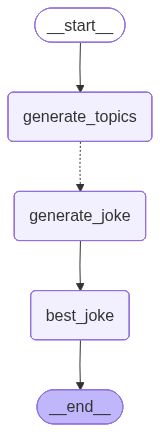

In [20]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# 构建图：把上述各个节点与边组合成完整图
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
# 并行生成笑话的节点
graph.add_node("generate_joke", generate_joke)
# 选择最佳笑话的节点
graph.add_node("best_joke", best_joke)
# 起始 -> 生成子主题
graph.add_edge(START, "generate_topics")
# 条件边：为每个子主题发送到 generate_joke，并行执行
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
# Map -> Reduce
graph.add_edge("generate_joke", "best_joke")
# 结束
graph.add_edge("best_joke", END)

# 编译图
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [21]:
# 调用图：以输入主题触发生成与选择流程
for s in app.stream({"topic": "小花猫"}):
    print(s)  # 逐步输出每一步状态，便于初学者观察执行顺序

{'generate_topics': {'subjects': ['小花猫的生活习性', '小花猫的健康与护理', '小花猫的品种与特征']}}


{'generate_joke': {'jokes': ['为什么小花猫总是拒绝去看兽医？\n\n因为它听说医生会给它开"猫"药！😸']}}


{'generate_joke': {'jokes': ['**小花猫的生活习性笑话**\n\n一天，小花猫和它的朋友小黑猫在阳光下懒洋洋地躺着。\n\n小黑猫问：“小花猫，你为什么总是喜欢在阳光下打盹呢？”\n\n小花猫懒懒地回答：“因为我在做光合作用啊！”\n\n小黑猫惊讶地说：“光合作用？你是植物吗？”\n\n小花猫得意地笑了：“当然不是，但我在吸收阳光，储存能量，晚上就能在家里跑酷了！”\n\n小黑猫无奈地摇摇头：“看来你真是个‘光’明正大的懒猫！”\n\n小花猫眯着眼睛，继续享受着阳光，心里想着："谁说猫不能有点植物的梦想呢？" 😸🌞']}}


{'generate_joke': {'jokes': ['**喵笑段子：高贵的喵种与毛色之谜🐱**\n\n在小镇的喵升级大会上，各种猫咪代表都前来展示各自的优越品种和特点。\n\n小花猫走上台，自豪地说：“我是波斯猫家族的后裔，毛发柔顺如丝，气质高贵至极。”\n\n白猫站在旁边，摇着头，满脸疑惑：“真的？你看上去颜色还挺丰富呢。”\n\n小花猫神秘一笑：“我只不过是披着一身花毛的波斯猫罢了。用彩色来增加神秘感，让人猜我到底是哪一种高贵的猫。”\n\n灰猫听后，神秘兮兮地附和：“原来如此，我也是波斯猫披着灰毛，只是为了在夜里更好藏身，顺便给家里的沙发来点惊喜脱毛艺术。”\n\n白猫睁大了眼睛：“那我是不是也披了毛色，才显得如此纯白？”\n\n小花猫笑着回答：“不，你是披着勇气和单纯的幸福，纯白如雪，让人忍不住想拍拍。”\n\n此刻，一旁的黑猫抱怨道：“所以，我的黑色是披着夜影催眠术？为什么大家都以为我在静悄悄打算些什么？”\n\n小花猫和白猫一同点头：“也许是，你在酝酿一场梦中探险呢！”\n\n整个大会现场，猫咪们一起笑成了一团，互相拍打着毛发，享受着自嘲和各自身上的特点。原来，最重要的不是披了什么毛，而是毛下那颗跳动的小小心脏，满载着机智和快乐。😺🤣']}}


{'best_joke': {'best_selected_joke': '**小花猫的生活习性笑话**\n\n一天，小花猫和它的朋友小黑猫在阳光下懒洋洋地躺着。\n\n小黑猫问：“小花猫，你为什么总是喜欢在阳光下打盹呢？”\n\n小花猫懒懒地回答：“因为我在做光合作用啊！”\n\n小黑猫惊讶地说：“光合作用？你是植物吗？”\n\n小花猫得意地笑了：“当然不是，但我在吸收阳光，储存能量，晚上就能在家里跑酷了！”\n\n小黑猫无奈地摇摇头：“看来你真是个‘光’明正大的懒猫！”\n\n小花猫眯着眼睛，继续享受着阳光，心里想着："谁说猫不能有点植物的梦想呢？" 😸🌞'}}


## Studio（可视化与本地开发）

**⚠️ 说明**

自课程视频录制后，Studio 已更新支持“本地运行并在浏览器打开”。这现在是推荐方式（而不是使用视频中演示的桌面应用）。

- 本地开发服务器说明见文档：[LangGraph Studio 本地开发服务](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server)
- 如何运行见文档：[运行本地 Studio](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server)

在本模块的 `/studio` 目录中，执行：

```
langgraph dev
```

你将看到类似输出：
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

用浏览器打开 Studio UI：`https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`。

我们将把上面的图在 Studio 中加载，对应到 `module-4/studio/langgraph.json` 中配置的 `module-4/studio/map_reduce.py`。